# Mod. Image Loader with Albumentation

Description: This notebook loads images from a directory, and handles imbalanced classes with down/re/upsampling and augmentation.

This notebook should be run from the top to the bottom, resulting in 3 files:

* `train_from_Metadata_processed.csv` - a csv file with the training data
* `validation_from_Metadata_processed.csv` - a csv file with the validation data
* `test_from_Metadata_processed.csv` - a csv file with the test data

These files encode the images with labels.


## Imports and inital setup

In [11]:
# Imports
import pandas as pd
import tensorflow as tf
#from tensorflow.keras.preprocessing.image import ImageDataGenerator
from albumentations import (Compose, RandomCrop, Normalize, HorizontalFlip, Resize, RandomBrightnessContrast, CoarseDropout, GridDistortion, HueSaturationValue, GaussianBlur,Rotate)
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

import os
import random
import sys

sys.path.append("..")
from helperfunctions import imagehelper as ih

SEED = 42
MAX_SAMPLES = 1000

# File path variables
# please make sure to use the correct path to the meta data file

FILEPATH_JPGS = './../data/jpgs/'
FILEPATH_METADATA="./../data/processed/Metadata_processed.csv"
FILEPATH_OUTPUT = './../data/jpgs/' 

TARGET_LABEL="dx" # Needed for test train split
BALANCE_LABEL="dx"      # Needed for balancing the dataset
IMAGE_SIZE = (224, 224)

### Deleting all previously augmented images in advance

In [12]:
# Define the bash script as a string
bash_script = """
#!/bin/bash

output_folder="./../data/jpgs/" 

# Delete images with the "aug_" prefix
find "$output_folder" -type f -name "aug_*" -delete

echo "Deleted augmented images with 'aug_' prefix in $output_folder"
"""

# Save the bash script to a file
with open('delete_augmented_images.sh', 'w') as script_file:
    script_file.write(bash_script)

# Make the script executable
!chmod +x delete_augmented_images.sh

# Execute the script
!./delete_augmented_images.sh

# Delete the script
!rm delete_augmented_images.sh

Deleted augmented images with 'aug_' prefix in ./../data/jpgs/


### Loading the metadata file

In [13]:
# Read the metadata file
metadata = pd.read_csv(FILEPATH_METADATA)

# Concatenate the base directory with the image filename to add the full path
metadata['image_path'] = FILEPATH_JPGS + metadata['image_id']

metadata.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset,dx_binary,image_path
0,HAM_0000118,ISIC_0027419.jpg,bkl,histo,80.0,male,scalp,vidir_modern,not_skin_cancer,./../data/jpgs/ISIC_0027419.jpg
1,HAM_0000118,ISIC_0025030.jpg,bkl,histo,80.0,male,scalp,vidir_modern,not_skin_cancer,./../data/jpgs/ISIC_0025030.jpg
2,HAM_0002730,ISIC_0026769.jpg,bkl,histo,80.0,male,scalp,vidir_modern,not_skin_cancer,./../data/jpgs/ISIC_0026769.jpg
3,HAM_0002730,ISIC_0025661.jpg,bkl,histo,80.0,male,scalp,vidir_modern,not_skin_cancer,./../data/jpgs/ISIC_0025661.jpg
4,HAM_0001466,ISIC_0031633.jpg,bkl,histo,75.0,male,ear,vidir_modern,not_skin_cancer,./../data/jpgs/ISIC_0031633.jpg


# Splitting the data in train, validation and test sets

In [14]:
# Splitting the data into train, validation and test using train_test_split

# Split the data into two subsets: train and temp (60% train, 40% temp)
train_df, temp_df = train_test_split(metadata, test_size=0.4, stratify=metadata[TARGET_LABEL], random_state=SEED)

# Split the temp data into validation and test sets (50% each)
validation_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df[TARGET_LABEL], random_state=SEED)

# resetting the index
train_df = train_df.reset_index(drop=True)
validation_df = validation_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

display(
    train_df.shape,
    validation_df.shape,
    test_df.shape
)

(6009, 10)

(2003, 10)

(2003, 10)

# Tackling Class imbalances in the training set

## Setting up the image data generator for augmentation

In [15]:

datagen_augment = Compose([
    HorizontalFlip(p=0.5),
    Rotate(limit=45, p=0.5),
    RandomBrightnessContrast(brightness_limit=0.2,contrast_limit=0.2, p=0.5),
    HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=0.5),
    #GaussianBlur(blur_limit=(3, 7), p=0.5),
    #CoarseDropout(max_holes=12, min_height= 3 ,max_height=12,min_width=3, max_width=12, p=0.5),
])

## Preparing data for augmentation

In [16]:
# Create separate DataFrames for every class  in the given BALANCE_LABEL column

class_dataframes = {}
for class_label in train_df[BALANCE_LABEL].unique():
    class_dataframes[class_label] = train_df[train_df[BALANCE_LABEL] == class_label]
    print(f"Class {class_label} has {class_dataframes[class_label].shape[0]} samples")
    #display(class_dataframes[class_label].head())

Class nv has 4023 samples
Class bcc has 308 samples
Class mel has 668 samples
Class akiec has 196 samples
Class vasc has 85 samples
Class bkl has 660 samples
Class df has 69 samples


In [17]:
# Initialize a dictionary to keep track of the number of augmented images per class
class_augmentation_counts = {class_label: 0 for class_label in class_dataframes.keys()}

# Create a list to store DataFrames for each class
augmented_dataframes = []

# Apply data augmentation for classes with few examples, trim classes with too many examples
for class_label, class_df in class_dataframes.items():
    
    # Describing the overall progress
    print(f"\nChecking class {class_label}...")

    # Calculate the number of images needed to reach MAX_SAMPLES for this class
    images_needed = MAX_SAMPLES - class_df.shape[0]
    
    # If images_needed is negative, randomly select MAX_SAMPLES from the class_df
    if images_needed < 0:
        print(f"> Result: Class {class_label} was reduced to {MAX_SAMPLES} samples")
        reduced_df = class_df.sample(n=MAX_SAMPLES, random_state=SEED)
        augmented_dataframes.append(reduced_df)
        continue
    # If images_needed is zero, skip this class
    elif images_needed == 0:
        print(f"> Result: Class {class_label} already has exactly {MAX_SAMPLES} samples")
        augmented_dataframes.append(class_df)
        continue

    # Generate augmented data - this part only runs if images_needed is positive
    print(f"> Result: Class {class_label} needs {images_needed} more images")
    augmented_dataframes.append(class_df)

    while class_augmentation_counts[class_label] <= images_needed:

        # Describing the subprocess progress for each class
        sys.stdout.write(f"\rProgress: {class_augmentation_counts[class_label]}/{images_needed}")
        sys.stdout.flush()

        # Randomly select an image from the class_df
        i = random.randint(0, class_df.shape[0] - 1)
        image_path = class_df.iloc[i]['image_path']

        # Load and preprocess the image
        img = ih.img_load_and_transform(image_path, IMAGE_SIZE)

        # Apply data augmentation via generator
        augmented_img = datagen_augment(image=img)['image']

        # Create a new image ID with prefix
        augmented_image_id = f'aug_{ih.generate_random_string()}' + os.path.basename(image_path)

        # Create a new image path with the augmented image ID as string
        augmented_image_path = FILEPATH_JPGS + augmented_image_id
        
        # Create a new DataFrame for the augmented data for this instance only
        augmented_instance_df = class_df.iloc[i:i+1].copy()
        
        # Reset the index of the new DataFrame
        augmented_instance_df.reset_index(drop=True, inplace=True)

        # Update the "image_id" column with the augmented image ID
        augmented_instance_df.at[0, 'image_id'] = augmented_image_id
        
        # Update the "image_path" column with the augmented image path
        augmented_instance_df.at[0, 'image_path'] = augmented_image_path
        
        # Append the augmented DataFrame for this instance to the list
        augmented_dataframes.append(augmented_instance_df)

        # Save the augmented image to the output folder
        augmented_image_path = os.path.join(FILEPATH_OUTPUT, augmented_image_id)
        plt.imsave(augmented_image_path, augmented_img)

        # Update the counter for the class
        class_augmentation_counts[class_label] += 1

# Combine all augmented DataFrames into a single DataFrame
balanced_train_df = pd.concat(augmented_dataframes, ignore_index=True)

balanced_train_df.shape



Checking class nv...
> Result: Class nv was reduced to 1000 samples

Checking class bcc...
> Result: Class bcc needs 692 more images
Progress: 692/692
Checking class mel...
> Result: Class mel needs 332 more images
Progress: 332/332
Checking class akiec...
> Result: Class akiec needs 804 more images
Progress: 804/804
Checking class vasc...
> Result: Class vasc needs 915 more images
Progress: 915/915
Checking class bkl...
> Result: Class bkl needs 340 more images
Progress: 340/340
Checking class df...
> Result: Class df needs 931 more images
Progress: 931/931

(7006, 10)

### Checking the image file folder

In [18]:
# Checking what's going on in the folder

def count_files_in_folder(folder_path):
    # Initialize counters
    total_files = 0
    aug_files = 0

    # Check if the folder exists
    if os.path.exists(folder_path):
        # List all files in the folder
        files = os.listdir(folder_path)
        
        # Count all files and files starting with "aug_"
        for file in files:
            total_files += 1
            if file.startswith("aug_"):
                aug_files += 1

        # Display the counts
        print(f"Total files in folder: {total_files}")
        print(f"Files starting with 'aug_': {aug_files}")
    else:
        print(f"Folder '{folder_path}' does not exist.")

# Example usage:
folder_path = "./../data/jpgs/"  # Replace with your folder path
count_files_in_folder(folder_path)


Total files in folder: 14037
Files starting with 'aug_': 4020


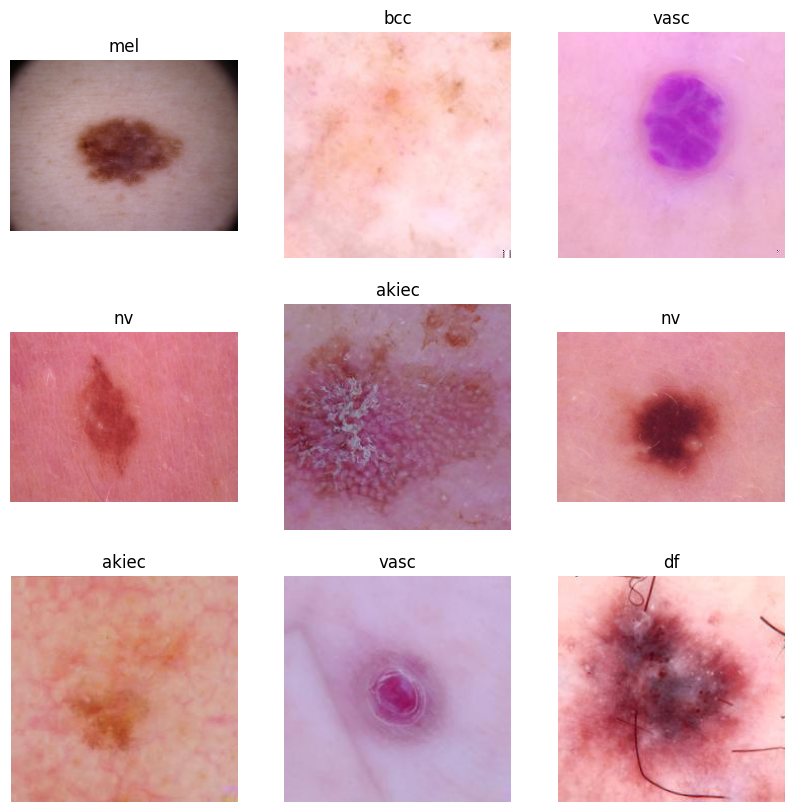

In [19]:
# Get a random sample of 9 images from the balanced_train_df
sample_df = balanced_train_df.sample(n=9, random_state=7)

# Create a list of image paths from the "image_path" column
image_paths = sample_df['image_path'].tolist()

# Create a list of image labels from the "dx" column
image_labels = sample_df['dx'].tolist()

# Load and plot the images without imagehelper
fig, axes = plt.subplots(3, 3, figsize=(10, 10))
axes = axes.ravel()
for i, image_path in enumerate(image_paths):
    img = plt.imread(image_path)
    axes[i].imshow(img)
    axes[i].set_title(image_labels[i])
    axes[i].axis('off')




## Saving Test, Validation and Training data to csv

In [20]:
balanced_train_df.to_csv('../data/processed/train_from_Metadata_processed.csv', index=False)
validation_df.to_csv('../data/processed/validation_from_Metadata_processed.csv', index=False)
test_df.to_csv('../data/processed/test_from_Metadata_processed.csv', index=False)